# RET data curation

- **RET (Rearranged during Transfection)** is a proto-oncogene that codes for a receptor tyrosine kinase. This means it produces a protein that plays a role in signaling pathways within cells, particularly related to cell growth and differentiation. When activated, RET helps regulate cell survival, proliferation, and differentiation. Mutations or alterations in the RET gene can lead to uncontrolled cell growth and potentially the development of cancer.
    - **RET wild type**:  In some cases, targeting both mutant and wild-type RET together can be more effective than targeting only one form as Combination Therapies.
    In certain cancer types, such as some subtypes of non-small cell lung cancer (NSCLC), the RET signaling pathway can interact with other oncogenic pathways, such as the EGFR (epidermal growth factor receptor) pathway. Targeting both pathways simultaneously might offer a synergistic effect and improve treatment outcomes.
    - **RET-V804L:** The V804L mutation causes a structural change in the RET protein, resulting in its continuous activation, even in the absence of ligand binding. The mutation leads to uncontrolled cell growth and division, contributing to oncogenesis. The V804L mutation in RET has been identified in various cancer types, particularly in thyroid cancers, including papillary thyroid carcinoma (PTC) and medullary thyroid carcinoma (MTC). It is often associated with aggressive tumor behavior and resistance to conventional therapies.
    V804L confers a gain of function on the Ret protein, as indicated by increased kinase activity, cell transformation (PMID: 9242375), and is considered a gatekeeper mutation due to lack of response to some inhibitors, including cabozantinib and vandetanib (PMID: 27712045).
    - **RET-Y791F:** The Y791F mutation disrupts a crucial phosphorylation site within the RET protein. Consequently, the tyrosine at position 791 cannot be phosphorylated effectively or at all. This disruption interferes with the normal signaling pathways that rely on this particular phosphorylation event, leading to dysregulated downstream signaling, such as MAPK and PI3K. The Y791F mutation, by abrogating this phosphorylation site, alters these cellular responses and may influence tumor development and progression. The Y791F mutation is found in the RET protein, which is implicated in several types of cancer, particularly medullary thyroid carcinoma (MTC). Y791F confers a gain of function on the Ret protein, resulting in ligand independent kinase activity and activation of Stat3 signaling through Src, Jak1, and Jak2-dependent pathways in cell culture (PMID: 15753368).

**Published RET datasets**: 
- **PKIS 1**: A set of 364 unique small-molecule ATP-competitive kinase inhibitors that was screened by the set in activity assays with 224 recombinant kinases and 24 G protein-coupled receptors and in cellular assays of cancer cell proliferation and angiogenesis. [ref]

**Description of readout:**
- **Readouts**: `RET`, `RET_(V804L_mutant)`, `RET_(Y791F_mutant)`
- **Bioassay readout**: Percentage of inhnibition.
- **Optimization objective**: Higher the more potent.

**Data pre-processing**

**Step 1** - Curate the chemistry information
  - Clean the molecules by perform molecule sanitization and fix, standardization molecules, salts/solvents removals.
  - Detect the stereochemistry information in the molecules. Such as undefined stereo centers and information. It's crucial in the case of the activity cliff among the stereoisomers.

<br>

**Step 2** - Curate the measured values
  - Identify the compounds which have multiple measures in the dataset. The identification of the repeated molecules is defined by `datamol.hash_mol` including stereochemistry information.
  - Verify the data resource and remove the dubious data points which are significant different or in different classes in case of categorical data. Compute the average of the rest of the duplicated molecules.
  - Detect potential outliers of the dataset. Verify the data resource and remove the dubious data points.
  - Convert the continuous values based on provided threshold values to classification tasks.
  - Detect activity cliff between the stereoisomers. Those isomers and their bioactivity values can be removed/masked from dataset if the downstream molecule representation is not able to differentiate the stereoisomers.

<br>

**Step 3** - Visual inspection
  - Access molecular diversity and distribution in the chemical space. This can guide the decision on which splitting approach to employ. 
  - Visualize the distribution of bioactivity values. It's useful to exam whether it's meaningful to convert to classification task.
  - Check molecules which contain undisered characters.

In [1]:
%load_ext autoreload
%autoreload 2
import datamol as dm
import pandas as pd
from polaris import curation
import numpy as np
import umap
import seaborn as sns
from matplotlib import pyplot as plt
import seaborn as sns
import os
from os import path
from os.path import dirname
os.chdir(path.dirname(path.dirname(path.abspath("__file__"))))

/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/lu.zhu/miniconda3/envs/pov3/lib/python3.11/site-packages/umap/d

In [2]:
# load data
data = pd.read_parquet(
    "gs://polaris-private/Datasets/Kinases/pkis1_curated_&_splits_2023-08-23.parquet"
)

In [3]:
# Define data column names
data_cols = ['RET_(V804L_mutant)', 'RET_(Y791F_mutant)', 'RET']
mol_col = "smiles"
data = data[[mol_col] + data_cols]

In [4]:
data.describe()[data_cols]

,RET_(V804L_mutant),RET_(Y791F_mutant),RET
count,364.000000,363.000000,363.000000
mean,18.036635,24.322438,21.859187
std,22.042406,24.474321,25.072311
min,-3.850000,-4.940000,-1.840000
25%,4.407500,7.135000,5.380000
50%,8.985000,13.870000,9.580000
75%,20.277500,33.555000,28.815000
max,87.820000,94.670000,93.610000


In [5]:
for data_col in data_cols: 
    display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())

/var/folders/_7/ffxc1f251dbb5msn977xl4sm0000gr/T/ipykernel_91822/1691884317.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  display(data[data_col].groupby(pd.cut(data[data_col], [0,70,75, 80, 90, 100])).count())


RET_(V804L_mutant)
(0, 70]      329
(70, 75]       5
(75, 80]       8
(80, 90]       9
(90, 100]      0
Name: RET_(V804L_mutant), dtype: int64

RET_(Y791F_mutant)
(0, 70]      320
(70, 75]       8
(75, 80]       7
(80, 90]      15
(90, 100]      4
Name: RET_(Y791F_mutant), dtype: int64

RET
(0, 70]      322
(70, 75]       6
(75, 80]       8
(80, 90]      17
(90, 100]      3
Name: RET, dtype: int64

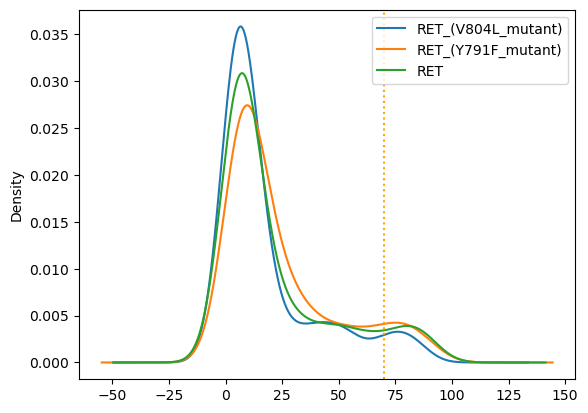

In [6]:
fig = data[data_cols].plot.kde()
plt.axvline(x=70, linestyle="dotted", color="orange")

### Perform data curation with `polaris.curation` module

In [7]:
# Define the threshold for classification conversion 
# we use the recommanded threshold 90% from the paper
# However, due to the number of active compounds and the above distribution
# We can lower the threshold to 70
th = 70
class_thresholds = {col: {"thresholds": [th]} for col in data_cols}

In [8]:
# curate
curator_with_stereo = curation.MolecularCurator(
    data=data,
    data_cols=data_cols,
    mol_col=mol_col,
    mask_stereo_undefined_mols=True,
    class_thresholds=class_thresholds
)
df_full = curator_with_stereo()

2023-10-18 00:38:01.370 | WARNING  | polaris.curation._data_curator:check_outliers:188 - Detected 4 outliers for data column RET_(V804L_mutant) using zscore. Please revise the data and consider remove the outliers. 
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff"] = True
/Users/lu.zhu/Documents/Codebase/ValenceLab/polaris/polaris/curation/_data_curator.py:77: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'True' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  data.loc[data[NO_STEREO_UNIQUE_ID].isin(mol_with_cliff), f"{data_col}_stereo_cliff

In [9]:
for col in data_cols:
    print(col)
    display(df_full.query(f'`OUTLIER_{col}` == True')[data_cols])

RET_(V804L_mutant)


,RET_(V804L_mutant),RET_(Y791F_mutant),RET
75,87.82,94.67,93.61
93,85.83,74.09,66.63
155,86.38,92.12,71.96
215,84.60,83.18,88.42


RET_(Y791F_mutant)


,RET_(V804L_mutant),RET_(Y791F_mutant),RET


RET


,RET_(V804L_mutant),RET_(Y791F_mutant),RET


The curation raised warning for potential outliers from the bioactivity readouts of RET V804L mutants. The outlier labels are added in the curated output.  It's important to revise those data points and verify whether they are real outliers and should be removed from the dataset. 

We can also use other outlier detection methods by passing parameters to `outlier_params`. Please see more details in `polaris.curation.utils.outlier_detection`. 

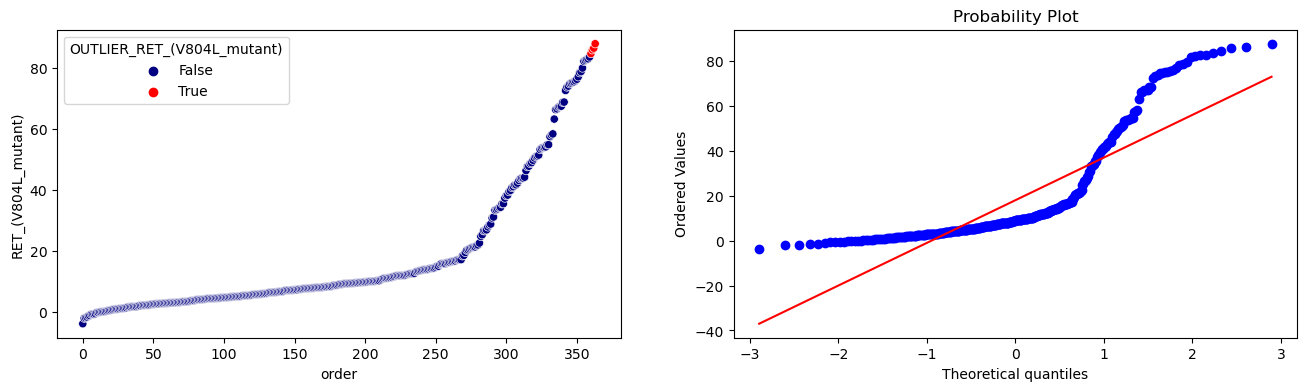

In [10]:
from utils import show_outliers
show_outliers(data=df_full, data_cols=["RET_(V804L_mutant)"])

The flagged outliers are likely false outliers as they are located on the terminals of the data distributions. 

### Check the compounds with undisered characters

In [11]:
from utils import basic_filter

In [12]:
processed_df = basic_filter(data = df_full, mol_col='smiles')

Filter by rules:   0%|          | 0/364 [00:00<?, ?it/s]

In [13]:
assert processed_df[processed_df.HasUndesiredEle].shape[0] == 0

There is no compounds which contains undiserable elements.

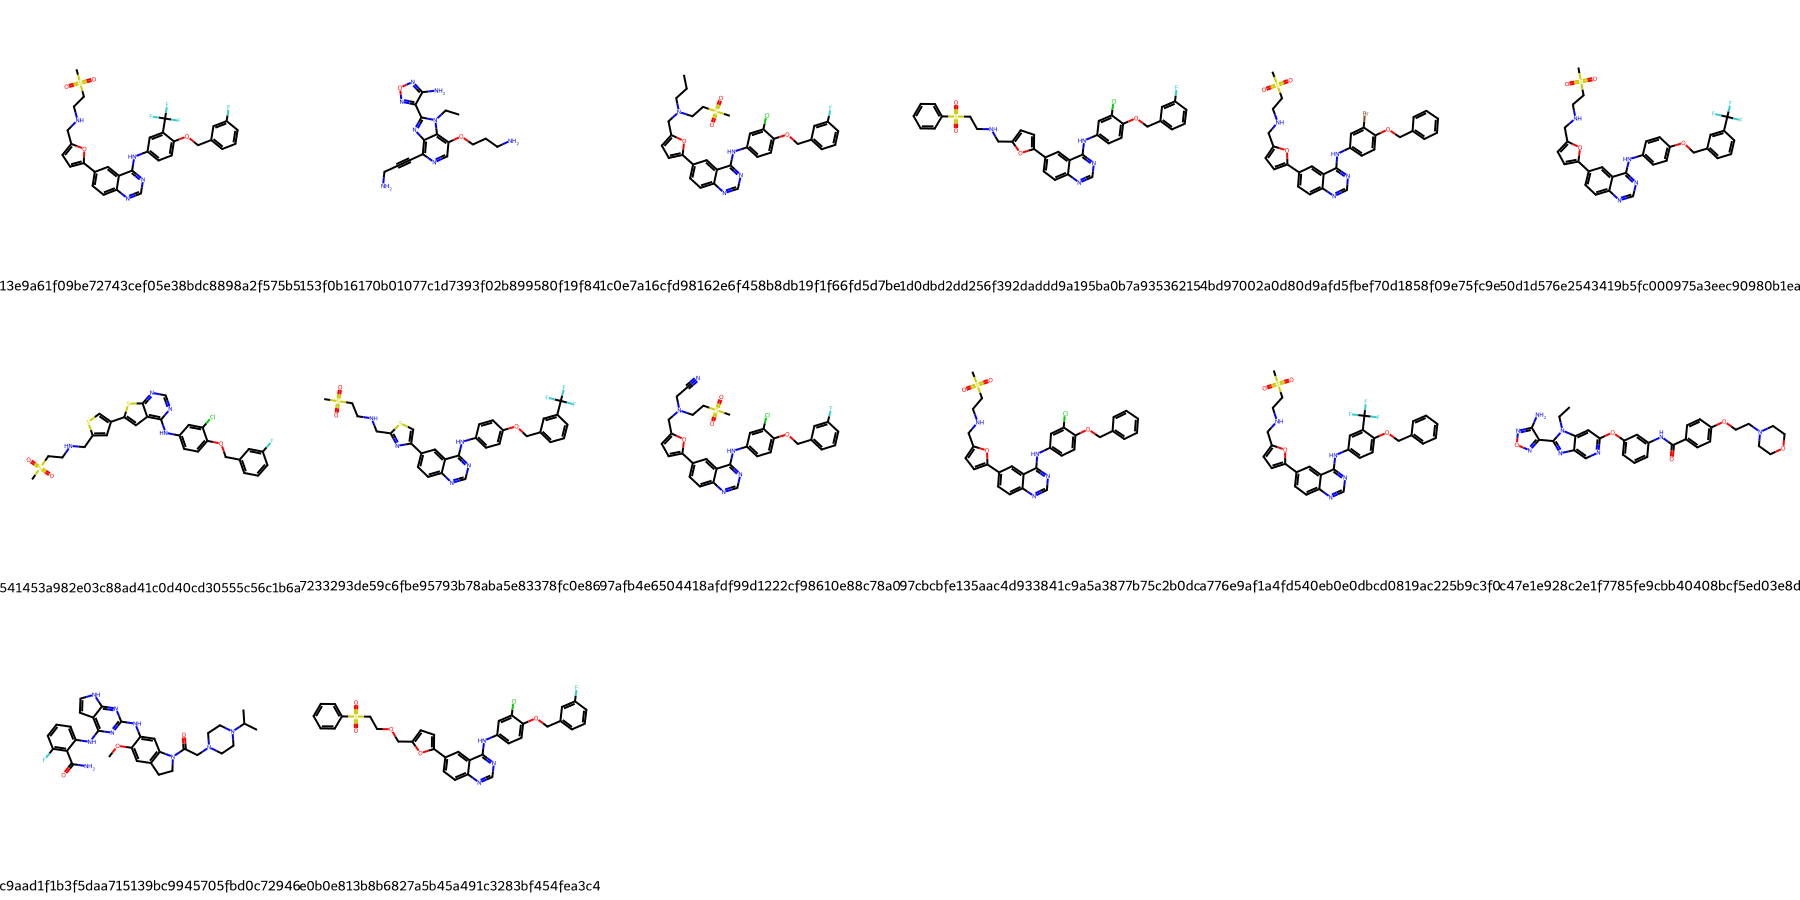

In [14]:
# visualize molecules which don't pass any of the nibr filters.
id_col = "molhash_id"
to_plot = processed_df[~processed_df.pass_any]
legends=to_plot[id_col].astype(str).tolist()
dm.to_image(to_plot['mol'].tolist(), 
            legends=legends, legendFraction=0.1,
            use_svg=True, n_cols=6)

NIBR filters are intended for molecule prioritization in the context of screening. \
Here we used to flag the molecules which are potentially undesired for the benchmark.\
From the above suggested molecules, there is no compound which contains striking unwanted substructure or extremely large groups. 

## Chemical space

In [15]:
mols = df_full.smiles.apply(dm.to_mol)
features = [dm.to_fp(mol) for mol in mols]

In [16]:
embedding = umap.UMAP().fit_transform(features)
df_full["UMAP_0"], df_full["UMAP_1"] = embedding[:, 0], embedding[:, 1]

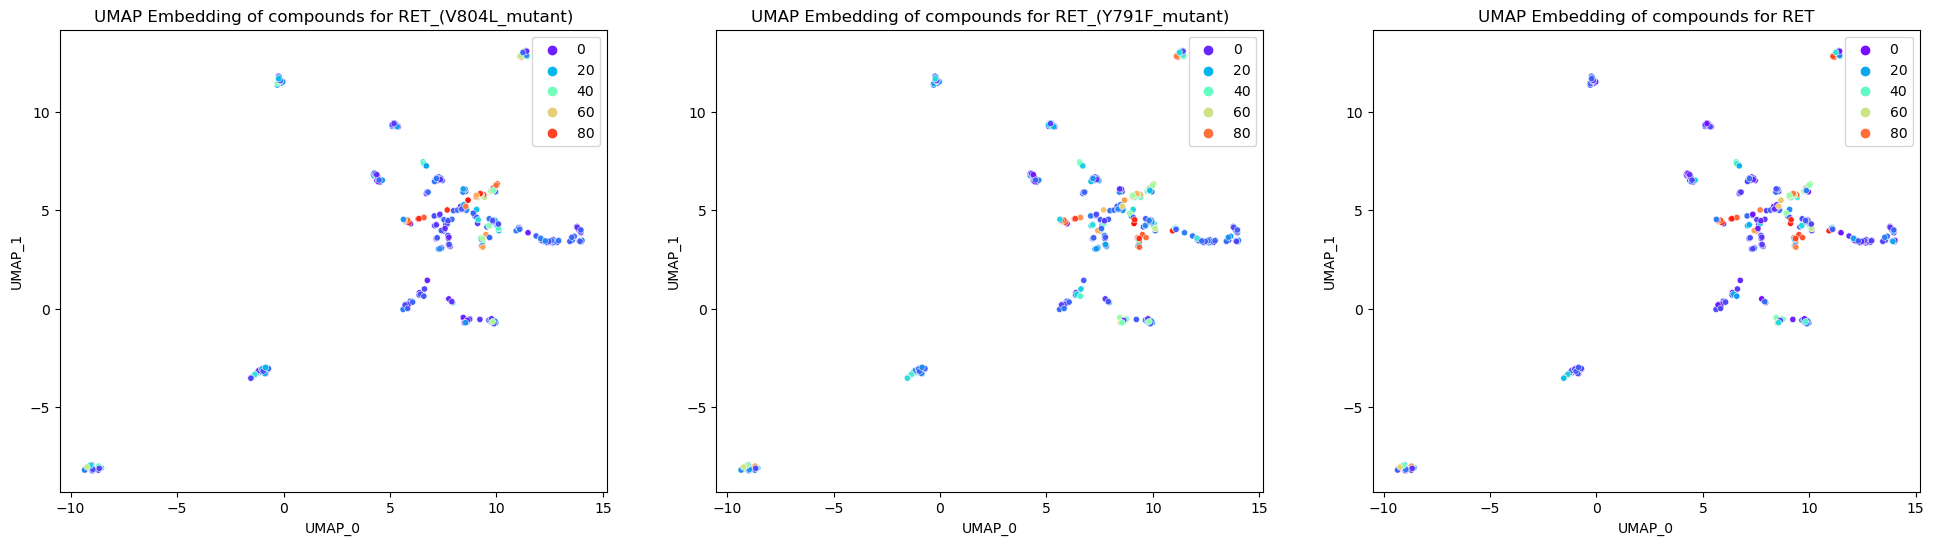

In [17]:
method = "UMAP"

fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(24, 6))
axes = axes.flatten()
for i, col in enumerate(data_cols):
    sns.scatterplot(
        data=df_full,
        x="UMAP_0",
        y="UMAP_1",
        palette="rainbow",
        hue=df_full[data_cols[i]].values,
        ax=axes[i],
        s=20,
    )
    axes[i].set_title(f"{method} Embedding of compounds for {col}")

With the above representation, the compounds spread in the chemical space. The goal are to 1) optimize the bioactivity % inhibition. 2) discovery of potential hits in new chemical space. Therefore a scaffold based split method is more relevant in this context. 

In [18]:
df_full.drop(columns=["UMAP_0", "UMAP_1"]).to_parquet( "gs://polaris-private/Data/Kinases/RET_mutants_curated.parquet", index=False)

## Dataset creation with `Polaris`

In [19]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit

from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification

In [20]:
from polaris.utils.types import HubOwner
owner = HubOwner(organizationId="PolarisTest", slug="polaristest")
owner.owner

'PolarisTest'

**Create the RET dataset with `polaris.Dataset`** 

In [21]:
# Load data
PATH = 'gs://polaris-private/Data/Kinases/RET_mutants_curated.parquet'
table = pd.read_parquet(PATH)

Not all the columns are necessary, only the columns which are useful for the benchmarks will be annotated. Here we only use the columns that were used for training in the original paper. 

It's necessary to specify the key bioactivity columns, molecules structures and identifiers in dataset with `ColumnAnnotation`. It is possible to add `user_attributes` with any key and values when is needed, such as `unit`, `organism`, `scale` and optimization `objective`. 

**Abbrevations for the endpoint objective**
- THTB: the higher the better
- TLTB: the lower the better

In [22]:
table.rename(columns={UNIQUE_ID: "UNIQUE_ID"}, inplace=True)

In [23]:
annotations = {
     'UNIQUE_ID': ColumnAnnotation(protocol='Molecular hash ID. See <datamol.mol.hash_mol>'),
     'smiles': ColumnAnnotation(protocol='Molecule SMILES string'),
     'RET_(V804L_mutant)': ColumnAnnotation(protocol='Percentage of inhibition on RET with mutation V804L_mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'V804L_mutant', 'target': 'RET'}),
     'RET_(Y791F_mutant)': ColumnAnnotation(protocol='Percentage of inhibition on RET with mutation Y791F mutant', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'PKIS1', 'mutation': 'Y791F_mutant', 'target': 'RET'}),
     'RET': ColumnAnnotation(protocol='Percentage of inhibition on RET wide type', user_attributes={'unit': '%', 'concentration': '1uM', 'organism': 'human', 'objective': 'THTB', 'source': 'https://pubmed.ncbi.nlm.nih.gov/26501955', 'mutation': 'None', 'target': 'EGFR'}),
     'CLASS_RET_(V804L_mutant)': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on RET V804L mutant', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'RET_(V804L_mutant)'}),
     'CLASS_RET_(Y791F_mutant)': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on RET Y791F mutant', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'RET_(Y791F_mutant)'}),
     'CLASS_RET': ColumnAnnotation(protocol='Binarized label based on the percentage of inhibition on RET wide type', user_attributes={'thresholds': f'[{th}]', 'label_order': 'ascending', 'ref_col': 'RET'})
}

**Create `Dataset` object**

In [24]:
dataset = Dataset(
    table=table[annotations.keys()],
    name="RET_mutants",
    description=f"Profile of kinase RET, and its mutants RET, RET_(V804L_mutant), RET_(Y791F_mutant).",
    source="https://pubmed.ncbi.nlm.nih.gov/26501955",
    annotations=annotations,
    owner=owner, 
    tags=["Kinase"]
)

In [25]:
# save the dataset
SAVE_DIR = "gs://polaris-private/Datasets/Kinases/RET_mutants"
dataset.to_json(SAVE_DIR)

'gs://polaris-private/Datasets/Kinases/RET_mutants/dataset.json'

In [26]:
fs = dm.fs.get_mapper(SAVE_DIR).fs
fs.ls(SAVE_DIR)

['polaris-private/Datasets/Kinases/RET_mutants/dataset.json',
 'polaris-private/Datasets/Kinases/RET_mutants/table.parquet']

## Benchmark creation with `Polaris`
Creating a benchmark involves setting up a standard dataset, designing the train-validation-test set and defining evaluation metrics which is used to establish baseline performance level. 

In [27]:
import pandas as pd
import datamol as dm
import numpy as np
from sklearn.model_selection import ShuffleSplit
import polaris 
from polaris.curation._chemistry_curator import SMILES_COL, UNIQUE_ID
from polaris.dataset import Dataset, ColumnAnnotation
from polaris.benchmark import SingleTaskBenchmarkSpecification, MultiTaskBenchmarkSpecification

## Load existing Dataset object

In [28]:
dataset = polaris.load_dataset("gs://polaris-private/Datasets/Kinases/RET_mutants/dataset.json")

In [29]:
# Visualize all information about the dataset
dataset

{
  "name": "RET_mutants",
  "description": "Profile of kinase RET, and its mutants RET, RET_(V804L_mutant), RET_(Y791F_mutant).",
  "tags": [
    "Kinase"
  ],
  "user_attributes": {},
  "owner": {
    "slug": "polaristest",
    "organization_id": "PolarisTest",
    "user_id": null,
    "owner": "PolarisTest"
  },
  "md5sum": "76513d5d0a3c09716416cc369a878801",
  "readme": "",
  "annotations": {
    "UNIQUE_ID": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {}
    },
    "smiles": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {}
    },
    "RET_(V804L_mutant)": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "human",
        "objective": "THTB",
        "source": "PKIS1",
        "mutation": "V804L_mutant",
        "target": "RET"
      }
    },
    "RET_(Y791F_mutant)": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "human",
        "objective": "THTB",
        "source": "PKIS1",
        "mutation": "Y791F_mutant",
        "target": "RET"
      }
    },
    "RET": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "unit": "%",
        "concentration": "1uM",
        "organism": "human",
        "objective": "THTB",
        "source": "https://pubmed.ncbi.nlm.nih.gov/26501955",
        "mutation": "None",
        "target": "EGFR"
      }
    },
    "CLASS_RET_(V804L_mutant)": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "thresholds": "[70]",
        "label_order": "ascending",
        "ref_col": "RET_(V804L_mutant)"
      }
    },
    "CLASS_RET_(Y791F_mutant)": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "thresholds": "[70]",
        "label_order": "ascending",
        "ref_col": "RET_(Y791F_mutant)"
      }
    },
    "CLASS_RET": {
      "is_pointer": false,
      "modality": "UNKNOWN",
      "description": null,
      "user_attributes": {
        "thresholds": "[70]",
        "label_order": "ascending",
        "ref_col": "RET"
      }
    }
  },
  "source": "https://pubmed.ncbi.nlm.nih.gov/26501955",
  "license": null,
  "cache_dir": "/Users/lu.zhu/Library/Caches/polaris/datasets/RET_mutants/76513d5d0a3c09716416cc369a878801"
}

# Create scaffold split for RET mutants 

In [30]:
# scaffold split
from partitio._scaffold_split import ScaffoldSplit
flag = True
TEST_SIZE = 0.2
while flag:
    nums_pos_test = []
    SEED = np.random.randint(1,1000,1)[0]
    SEED = 665
    splitter = ScaffoldSplit(smiles=dataset.table.smiles.values, n_jobs=-1, test_size=TEST_SIZE, random_state=SEED)
    scaffold_split = next(splitter.split(X=dataset.table.smiles.values))
    for data_col in data_cols:
        num_pos_test = dataset.table.loc[scaffold_split[1], f"CLASS_{data_col}"].sum()
        nums_pos_test.append(num_pos_test)
    flag = min(nums_pos_test) < 10

In [31]:
print(SEED, nums_pos_test)

665 [10.0, 10.0, 12.0]


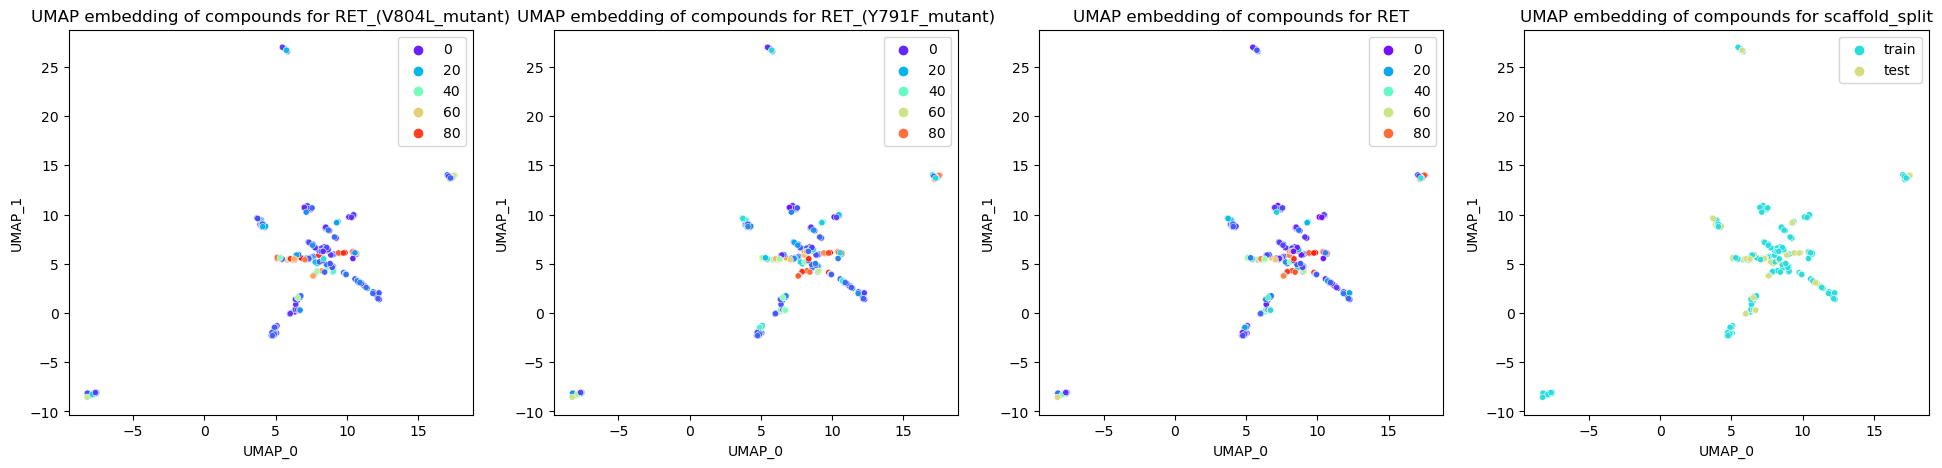

In [32]:
from utils import display_umap
fig = display_umap(df_full, 'smiles', split =scaffold_split, split_name="scaffold_split", data_cols=data_cols)

## Multitask for all the RET endpoints with a common Scaffold split. 

**Regression**

In [33]:
data_cols = ['RET_(V804L_mutant)', 'RET_(Y791F_mutant)', 'RET']
name ="RET_mutants_multitask_reg"
BENCHMARK_DIR = f"gs://polaris-private/benchmarks/Kinases/{name}"

benchmark_reg = MultiTaskBenchmarkSpecification(
    name=name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    metrics="mean_squared_error",
    tags=["Kinase", "MultiTask", "Regression", "HitDiscovery"],
    owner=owner, 
    description="Regression benchmark for RET wild type, V804L, Y791F mutants.",
)
path = benchmark_reg.to_json(BENCHMARK_DIR)
print(path)

gs://polaris-private/benchmarks/Kinases/RET_mutants_multitask_reg/benchmark.json


**Classification**

In [34]:
data_cols = ['CLASS_RET_(V804L_mutant)', 'CLASS_RET_(Y791F_mutant)', 'CLASS_RET']
name ="RET_mutants_multitask_clf"
BENCHMARK_DIR = f"gs://polaris-private/benchmarks/Kinases/{name}"

benchmark_clf = MultiTaskBenchmarkSpecification(
    name=name,
    dataset=dataset,
    target_cols=data_cols,
    input_cols="smiles",
    split=scaffold_split,
    metrics="accuracy",
    tags=["Kinase", "MultiTask", "Classification", "HitDiscovery"],
    description="Classification benchmark for RET wild type, V804L, Y791F mutants.",
    owner=owner
)
path = benchmark_clf.to_json(BENCHMARK_DIR)
print(path)

gs://polaris-private/benchmarks/Kinases/RET_mutants_multitask_clf/benchmark.json
